In [ ]:
# Mount Google Drive (replace with your authentication code if needed)
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Set the path to your dataset in Google Drive (replace with your actual path)
data_dir = '/content/gdrive/MyDrive/Plant Disease Recognition'  # Update with your actual path


In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Define image dimensions
img_width, img_height = 224, 224

# Data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)


In [ ]:
# Load training data (check for directory before loading)
print("Checking for training data directory:", data_dir + '/Train')
train_generator = train_datagen.flow_from_directory(
    data_dir + '/Train',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)


Checking for training data directory: /content/gdrive/MyDrive/Plant Disease Recognition/Train
Found 1333 images belonging to 3 classes.


In [ ]:
# Data augmentation (less aggressive) for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Load validation data
validation_generator = validation_datagen.flow_from_directory(
    data_dir + '/Validation',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)


Found 60 images belonging to 3 classes.


In [ ]:
# Define the CNN model (more complex with dropout for regularization)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Introduce dropout for regularization
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes (healthy, powdery mildew, rust)
])


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/20
42/42 [==============================] - 440s 10s/step - loss: 1.5378 - accuracy: 0.4096 - val_loss: 0.9765 - val_accuracy: 0.5167
Epoch 2/20
42/42 [==============================] - 245s 6s/step - loss: 0.7735 - accuracy: 0.6167 - val_loss: 0.5888 - val_accuracy: 0.7333
Epoch 3/20
42/42 [==============================] - 245s 6s/step - loss: 0.5152 - accuracy: 0.7839 - val_loss: 0.4344 - val_accuracy: 0.8833
Epoch 4/20
42/42 [==============================] - 243s 6s/step - loss: 0.4096 - accuracy: 0.8575 - val_loss: 0.4997 - val_accuracy: 0.8500
Epoch 5/20
42/42 [==============================] - 235s 6s/step - loss: 0.2760 - accuracy: 0.9070 - val_loss: 0.4195 - val_accuracy: 0.9167
Epoch 6/20
42/42 [==============================] - 247s 6s/step - loss: 0.2206 - accuracy: 0.9212 - val_loss: 0.3535 - val_accuracy: 0.9167
Epoch 7/20
42/42 [==============================] - 239s 6s/step - loss: 0.2281 - accuracy: 0.9347 - val_loss: 0.3341 - val_accuracy: 0.9000
Epoch 8/20
4

In [ ]:
# Function to preprocess the input image
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_input_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array


In [ ]:
# Function to make a prediction
def predict_disease(model, img_array):
    predictions = model.predict(img_array)
    class_indices = train_generator.class_indices
    class_names = list(class_indices.keys())
    predicted_class = class_names[np.argmax(predictions)]
    return predicted_class


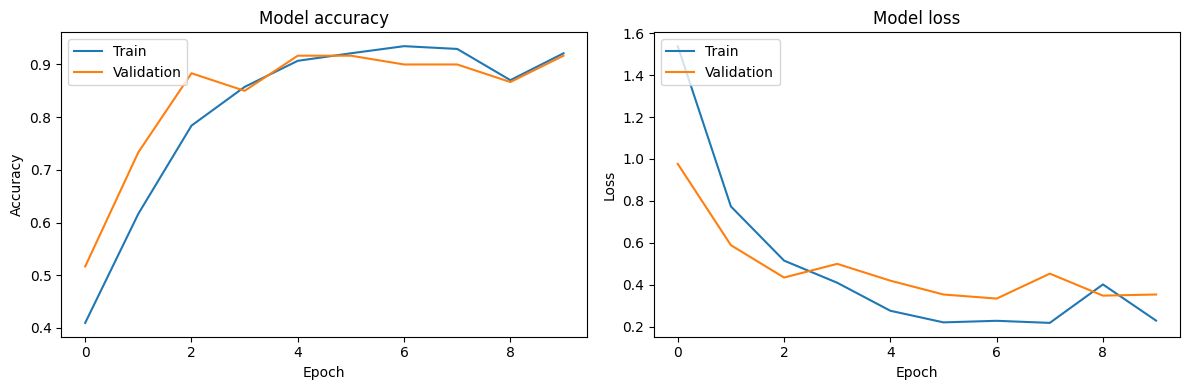

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


2/2 [==============================] - 15s 3s/step


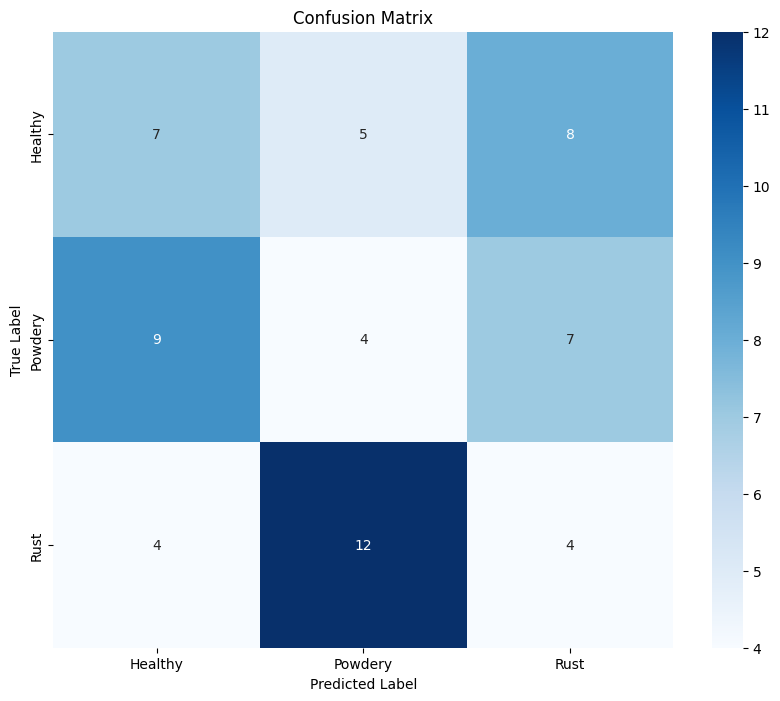

Classification Report
              precision    recall  f1-score   support

     Healthy       0.35      0.35      0.35        20
     Powdery       0.19      0.20      0.20        20
        Rust       0.21      0.20      0.21        20

    accuracy                           0.25        60
   macro avg       0.25      0.25      0.25        60
weighted avg       0.25      0.25      0.25        60



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predicted labels
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(report)


In [ ]:
# Example usage
img_path = '/content/gdrive/MyDrive/Plant Disease Recognition/Test/Powdery/80bc7d353e163e85.jpg'  # Update with your test image path
img_array = preprocess_input_image(img_path)
predicted_class = predict_disease(model, img_array)
print(f'The predicted class is: {predicted_class}')


1/1 [==============================] - 0s 191ms/step
The predicted class is: Powdery
